In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
from jaxtyping import Key, Array
import optax
import tensorflow_probability.substrates.jax.distributions as tfd
from sklearn import datasets
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from models import ResidualNetwork

In [2]:
class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, mlp_kwargs, *, key):
        self.net = eqx.nn.MLP(**mlp_kwargs, key=key)

    def __call__(self, x_t, t):
        return self.encode(x_t, t)
    
    def variational_posterior_log_prob(self, key, x_0, x_t, t):
        # This is the score of log(q(z|x_t, t))
        mu_t, sigma_t = self.encode(x_t, t)
        # Encode input data
        mu_0, sigma_0 = self.encode(x_0, 0.) # z ~ q(z|x_0, 0), as per diagram
        z = jr.multivariate_normal(key, mu_0, jnp.diag(sigma_0))
        return jax.scipy.stats.multivariate_normal.logpdf(z, mu_t, jnp.diag(sigma_t))

    def encode(self, x_t, t):
        t = jnp.atleast_1d(t)
        x_t_t = jnp.concatenate([x_t.flatten(), t])
        mu_t, log_sigma_t = jnp.split(self.net(x_t_t), 2)
        return mu_t, jnp.exp(log_sigma_t)

    def score(self, key, x, x_t, t): 
        # Score of variational distribution q(z|x_t, t) defined by encoder
        return jax.jacfwd(self.variational_posterior_log_prob, argnums=2)(key, x, x_t, t)

    def prior_log_prob_z(self, z):
        return jax.scipy.stats.norm.logpdf(z).sum() # Unit Gaussian 

In [3]:
key = jr.key(0)

score_network = ResidualNetwork(
    in_size=2, 
    out_size=2, 
    width_size=128, 
    depth=2, 
    y_dim=1, # Just scalar time
    activation=jax.nn.gelu, 
    key=key
)

score_network = eqx.tree_deserialise_leaves("sgm.eqx", score_network)

encoder = Encoder(
    dict(
        in_size=2 + 1, # [x_t, t]
        out_size=1 + 1, # Latent dim = 1, outputing mu, sigma
        width_size=32, 
        depth=2, 
        activation=jax.nn.tanh
    ),
    key=key
)

In [4]:
def kl_loss(mu, sigma):
    # Assuming sigma is diagonal elements of covariance
    return mu.T @ mu + sigma.sum() - mu.size - jnp.prod(sigma)


int_beta = lambda t: t  # Try experimenting with other options here!
weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.


def dataloader(x, batch_size, *, key):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        key, subkey = jr.split(key, 2)
        perm = jr.permutation(subkey, indices)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield x[batch_perm]
            start = end
            end = start + batch_size


def single_loss_fn(encoder, score_network, weight, int_beta, x, t, key):
    # Encoder training objective given trained diffusion model
    key_score, key_noise = jr.split(key)
    t = jnp.atleast_1d(t)

    # Diffusion loss calculations
    mean = x * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1. - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key_noise, x.shape)
    x_t = mean + std * noise

    mu_t, sigma_t = encoder.encode(x_t, t)

    _score = score_network(x_t, t) 
    _score_encoder = encoder.score(key_score, x, x_t, t) # d_(x_t)[log q(z|x_t, t)]
    score = _score + _score_encoder # Bayes rule for scores

    # Score of encoder model plus score of diffusion model
    return weight(t) * jnp.square(score + noise / std) - kl_loss(mu_t, sigma_t)


def batch_loss_fn(encoder, score_network, weight, int_beta, x, t1, key):
    batch_size = x.shape[0]
    key_t, key_L = jr.split(key)
    keys = jr.split(key_L, batch_size)

    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(key_t, (batch_size,), minval=0., maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)

    loss_fn = partial(single_loss_fn, encoder, score_network, weight, int_beta)
    return jnp.mean(jax.vmap(loss_fn)(x, t, keys))


# @eqx.filter_jit
def make_step(encoder, score_network, weight, int_beta, x, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(encoder, score_network, weight, int_beta, x, t1, key)
    updates, opt_state = opt_update(grads, opt_state, encoder)
    encoder = eqx.apply_updates(encoder, updates)
    key = jr.split(key, 1)[0]
    return loss, encoder, key, opt_state

In [5]:
opt = optax.adamw(1e-3)
opt_state = opt.init(eqx.filter(encoder, eqx.is_array)) # Gradients only needed for encoder

In [6]:
X, Y = datasets.make_moons(10_000, noise=0.05)
X, Y = jnp.asarray(X), jnp.asarray(Y)[:, jnp.newaxis]

In [7]:
key, train_key, loader_key = jr.split(key, 3) 

t1 = 1.
batch_size = 1000 
lr = 1e-3
num_steps = 1_000

int_beta = lambda t: t  # Try experimenting with other options here!
weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.

total_value = 0
total_size = 0
with trange(num_steps) as bar:
    for step, data in zip(bar, dataloader(X, batch_size, key=loader_key)):

        value, encoder, train_key, opt_state = make_step(
            encoder, 
            score_network, 
            weight, 
            int_beta, 
            data, 
            t1, 
            train_key, 
            opt_state, 
            opt.update
        )

        total_value += value.item()
        total_size += 1
        if (step % 100) == 0 or step == num_steps - 1:
            bar.set_postfix_str(f"Loss={total_value / total_size:.3E}")
            total_value = 0
            total_size = 0

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
@partial(jax.jacfwd, argnums=2)
def q_z_x_t_t(encoder, z, x_t, t):
    # Score (given wrapper) of variational posterior
    mu_t, sigma_t = encoder.encode(x_t, t)
    return jax.scipy.stats.multivariate_normal.logpdf(z, mu_t, jnp.diag(sigma_t))


@eqx.filter_jit
def single_sample_fn(
    score_network, encoder, int_beta, data_shape, latent_shape, dt0, t1, key
):

    def drift(t, y, args):
        (z, encoder) = args
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        score_q = q_z_x_t_t(encoder, z, y, t)
        score = score_network(y, t)
        return -0.5 * beta * (y + (score + score_q)) # Order changed for ResNet

    key_y1, key_z = jr.split(key)
    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0.
    y1 = jr.normal(key_y1, data_shape)
    z = jr.normal(key_z, latent_shape) # Sample latents like a VAE
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, args=(z, encoder)) # Reverse time, solve from t1 to t0
    return sol.ys[0]

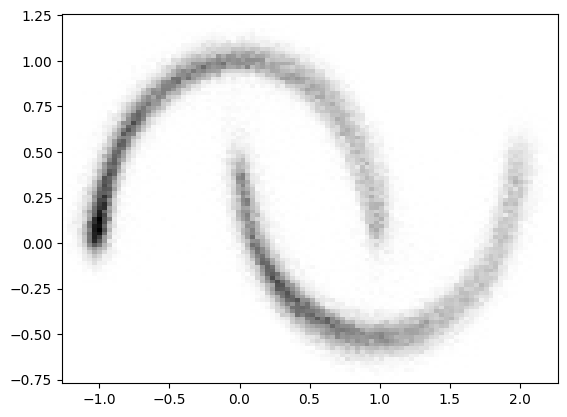

In [ ]:
data_shape = X.shape[1:]
latent_shape = (1,)
dt0 = 0.01
sample_size = 100_000

key, sample_key = jr.split(key)
sample_key = jr.split(sample_key, sample_size)
sample_fn = partial(
    single_sample_fn, 
    score_network, 
    encoder, 
    int_beta, 
    data_shape, 
    latent_shape, 
    dt0, 
    t1
)
sample = jax.vmap(sample_fn)(sample_key)

plt.figure()
plt.hist2d(*sample.T, bins=100, cmap="gray_r")
plt.show()

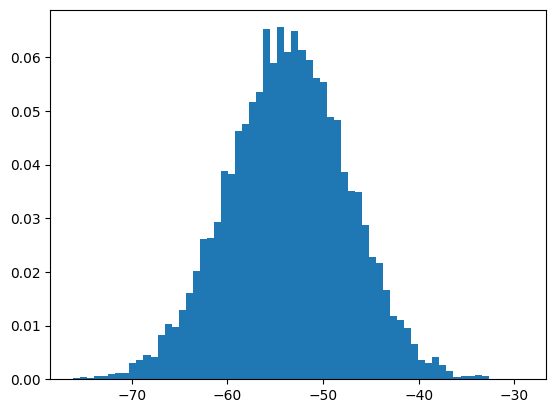

In [ ]:
mu, sigma = jax.vmap(encoder.encode, in_axes=(0, None))(X, 0.)
Z = mu + jr.normal(key, (len(X),)) * sigma

plt.hist(Z.flatten(), bins=64, density=True)
plt.show()